In [1]:
# Random forest model for EMA crossover identifier
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_path = Path('../Resources/ts_emax_x_squeeze.csv')
csv_path

PosixPath('../Resources/ts_emax_x_squeeze.csv')

In [3]:
ts_file_df = pd.read_csv(csv_path, parse_dates=[['Date', 'Time']])
ts_file_df.tail()

,Date_Time,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,MidLine.1,FastEMA,SlowEMA,squeeze,emax_signal
19600,2021-01-12 14:00:00,140.46,140.58,140.34,140.46,152792,140537,142.13,139.93,141.03,141.69,140.37,141.03,140.76,140.44,1,0
19601,2021-01-12 14:15:00,140.47,140.92,140.47,140.60,170378,174631,142.04,139.98,141.01,141.69,140.33,141.01,140.73,140.46,1,0
19602,2021-01-12 14:30:00,140.61,140.75,140.42,140.48,177439,178475,141.98,139.99,140.99,141.71,140.27,140.99,140.68,140.46,1,0
19603,2021-01-12 14:45:00,140.47,140.50,140.10,140.17,205777,182808,141.92,139.99,140.95,141.76,140.15,140.95,140.58,140.43,1,0
19604,2021-01-12 15:00:00,140.18,140.63,140.14,140.21,502297,446696,141.81,139.98,140.89,141.72,140.06,140.89,140.51,140.41,1,0


In [4]:
# set index as Date_Time and drop MidLine.1 column (it is a duplicate of MidLine)
ts_file_df.set_index(pd.to_datetime(ts_file_df['Date_Time'], infer_datetime_format=True), inplace=True)
ts_file_df.drop(columns=['Date_Time', 'MidLine.1'], inplace=True)
ts_file_df.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze,emax_signal
Date_Time,,,,,,,,,,,,,,,
2018-01-12 08:45:00,111.65,111.98,110.84,111.22,1051611,1206429,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0,0
2018-01-12 09:00:00,111.21,112.04,111.17,111.93,645133,604771,0.0,0.0,0.0,0.0,0.0,111.93,111.93,0,0
2018-01-12 09:15:00,111.93,112.20,111.87,112.13,541130,492175,0.0,0.0,0.0,0.0,0.0,111.97,111.95,0,0
2018-01-12 09:30:00,112.13,112.18,111.56,111.91,332412,418068,0.0,0.0,0.0,0.0,0.0,111.96,111.94,0,0
2018-01-12 09:45:00,111.91,112.24,111.85,111.97,281205,290538,0.0,0.0,0.0,0.0,0.0,111.96,111.95,0,0


In [5]:
# Set a variable list of features to feed to our model

x_var_list = ['Open', 'High', 'Low', 'Close', 'Up', 'Down', 'kcup', 'kclo', 'MidLine', 'bbup', 'bblo', 'FastEMA', 'SlowEMA']
ts_file_df[x_var_list].head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2018-01-12 08:45:00,111.65,111.98,110.84,111.22,1051611,1206429,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2018-01-12 09:00:00,111.21,112.04,111.17,111.93,645133,604771,0.0,0.0,0.0,0.0,0.0,111.93,111.93
2018-01-12 09:15:00,111.93,112.20,111.87,112.13,541130,492175,0.0,0.0,0.0,0.0,0.0,111.97,111.95
2018-01-12 09:30:00,112.13,112.18,111.56,111.91,332412,418068,0.0,0.0,0.0,0.0,0.0,111.96,111.94
2018-01-12 09:45:00,111.91,112.24,111.85,111.97,281205,290538,0.0,0.0,0.0,0.0,0.0,111.96,111.95


In [6]:
# Shift DataFrame values by 1
ts_file_df[x_var_list] = ts_file_df[x_var_list].shift(1)
ts_file_df[x_var_list].head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2018-01-12 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-12 09:00:00,111.65,111.98,110.84,111.22,1051611.0,1206429.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2018-01-12 09:15:00,111.21,112.04,111.17,111.93,645133.0,604771.0,0.0,0.0,0.0,0.0,0.0,111.93,111.93
2018-01-12 09:30:00,111.93,112.20,111.87,112.13,541130.0,492175.0,0.0,0.0,0.0,0.0,0.0,111.97,111.95
2018-01-12 09:45:00,112.13,112.18,111.56,111.91,332412.0,418068.0,0.0,0.0,0.0,0.0,0.0,111.96,111.94


In [7]:
ts_file_df.dropna(inplace=True)
ts_file_df.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze,emax_signal
Date_Time,,,,,,,,,,,,,,,
2018-01-12 09:00:00,111.65,111.98,110.84,111.22,1051611.0,1206429.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0,0
2018-01-12 09:15:00,111.21,112.04,111.17,111.93,645133.0,604771.0,0.0,0.0,0.0,0.0,0.0,111.93,111.93,0,0
2018-01-12 09:30:00,111.93,112.20,111.87,112.13,541130.0,492175.0,0.0,0.0,0.0,0.0,0.0,111.97,111.95,0,0
2018-01-12 09:45:00,112.13,112.18,111.56,111.91,332412.0,418068.0,0.0,0.0,0.0,0.0,0.0,111.96,111.94,0,0
2018-01-12 10:00:00,111.91,112.24,111.85,111.97,281205.0,290538.0,0.0,0.0,0.0,0.0,0.0,111.96,111.95,0,0


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [9]:
# Construct training start and training end dates

training_start = ts_file_df.index.min().strftime(format='%Y-%m-%d')
training_end = '2019-01-11'

# Construct test start and test end dates

testing_start = '2019-01-12'
testing_end = '2019-06-12'

# Construct validating start and validating end dates

vali_start = '2019-06-13'
vali_end = '2020-01-12'

# Confirming training, testing and validating dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")
print(f"validating Start: {vali_start}")
print(f"validating end: {vali_end}")

Training Start: 2018-01-12
Training End: 2019-01-11
Testing Start: 2019-01-12
Testing End: 2019-06-12
validating Start: 2019-06-13
validating end: 2020-01-12


In [15]:
# Construct the X_train and y_train datasets
X_train = ts_file_df[x_var_list][training_start:training_end]
y_train = ts_file_df['emax_signal'][training_start:training_end]

X_train.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2018-01-12 09:00:00,111.65,111.98,110.84,111.22,1051611.0,1206429.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2018-01-12 09:15:00,111.21,112.04,111.17,111.93,645133.0,604771.0,0.0,0.0,0.0,0.0,0.0,111.93,111.93
2018-01-12 09:30:00,111.93,112.20,111.87,112.13,541130.0,492175.0,0.0,0.0,0.0,0.0,0.0,111.97,111.95
2018-01-12 09:45:00,112.13,112.18,111.56,111.91,332412.0,418068.0,0.0,0.0,0.0,0.0,0.0,111.96,111.94
2018-01-12 10:00:00,111.91,112.24,111.85,111.97,281205.0,290538.0,0.0,0.0,0.0,0.0,0.0,111.96,111.95


In [16]:
y_train.tail()

Date_Time
2019-01-11 14:00:00    0
2019-01-11 14:15:00    0
2019-01-11 14:30:00    0
2019-01-11 14:45:00    0
2019-01-11 15:00:00    0
Name: emax_signal, dtype: int64

In [17]:
# Construct the X test and y test datasets

X_test = ts_file_df[x_var_list][testing_start:testing_end]
y_test = ts_file_df['emax_signal'][testing_start:testing_end]

X_test.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2019-01-14 08:45:00,100.09,100.16,99.88,99.93,538000.0,839750.0,100.32,99.54,99.93,100.22,99.64,99.99,99.95
2019-01-14 09:00:00,98.85,100.07,98.66,100.00,662220.0,467174.0,100.45,99.47,99.96,100.14,99.78,99.99,99.96
2019-01-14 09:15:00,99.98,100.22,99.73,100.14,315701.0,326009.0,100.50,99.47,99.98,100.12,99.85,100.02,99.97
2019-01-14 09:30:00,100.15,100.94,100.08,100.88,338536.0,318028.0,100.61,99.46,100.04,100.44,99.63,100.19,100.06
2019-01-14 09:45:00,100.88,101.01,100.43,100.68,328545.0,363630.0,100.68,99.46,100.07,100.56,99.58,100.29,100.11


In [18]:
y_test.head()

Date_Time
2019-01-14 08:45:00    0
2019-01-14 09:00:00    0
2019-01-14 09:15:00    0
2019-01-14 09:30:00    0
2019-01-14 09:45:00    0
Name: emax_signal, dtype: int64

In [19]:
# Construct the X valid and y validation datasets

X_vali = ts_file_df[x_var_list][vali_start:vali_end]
y_vali = ts_file_df['emax_signal'][vali_start:vali_end]

X_vali.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA
Date_Time,,,,,,,,,,,,,
2019-06-13 08:45:00,109.01,109.30,109.00,109.27,475047.0,353967.0,109.66,108.71,109.18,109.44,108.92,109.19,109.36
2019-06-13 09:00:00,109.46,110.09,109.39,110.06,182719.0,288328.0,109.74,108.69,109.22,109.67,108.76,109.37,109.42
2019-06-13 09:15:00,110.07,110.16,109.69,109.85,179614.0,123755.0,109.79,108.69,109.24,109.76,108.71,109.46,109.46
2019-06-13 09:30:00,109.85,109.99,109.43,109.43,158128.0,180381.0,109.81,108.69,109.25,109.78,108.72,109.46,109.46
2019-06-13 09:45:00,109.43,109.56,109.32,109.46,94904.0,99241.0,109.83,108.72,109.28,109.79,108.76,109.46,109.46


In [20]:
y_vali.tail()

Date_Time
2020-01-10 14:00:00    0
2020-01-10 14:15:00    0
2020-01-10 14:30:00    0
2020-01-10 14:45:00    0
2020-01-10 15:00:00    0
Name: emax_signal, dtype: int64

In [ ]:
# StandardScaler 

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [23]:
# Creating the StandardScaler instant 
scaler = StandardScaler()

In [24]:
# Feeding StandardScaler for X_train, X_test, X_vali
X_scaler_train = scaler.fit(X_train)

In [27]:
# Scaling the data 
X_train_scaled = X_scaler_train.transform(X_train)

In [30]:
X_test_scaled = X_scaler_train.transform(X_test)

In [31]:
X_vali_scaled = X_scaler_train.transform(X_vali)

In [32]:
# Import SKLearn library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [33]:
# Fit SKLearn regression with training datasets:
model = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=1)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1)

In [34]:
# Make predictions of "y" values from the X_test dataset
predictions = model.predict(X_test_scaled)

In [37]:
# Assemble actual y_test with predicted values

compare_predict_df = y_test.to_frame()
compare_predict_df["predict_emax"] = predictions

compare_predict_df

,emax_signal,predict_emax
Date_Time,,
2019-01-14 08:45:00,0,0
2019-01-14 09:00:00,0,0
2019-01-14 09:15:00,0,0
2019-01-14 09:30:00,0,0
2019-01-14 09:45:00,0,0
...,...,...
2019-06-12 14:00:00,0,0
2019-06-12 14:15:00,0,0
2019-06-12 14:30:00,0,0


In [44]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model_emax.joblib')

['random_forest_model_emax.joblib']

In [46]:
X_test_scaled

array([[-1.97370038, -1.9832091 , -1.97717584, ..., -1.91399824,
        -1.98332092, -1.98734584],
       [-2.09346294, -1.99191212, -2.09485281, ..., -1.90059544,
        -1.98332092, -1.98637681],
       [-1.98432447, -1.97740708, -1.99164432, ..., -1.89389405,
        -1.98042011, -1.98540779],
       ...,
       [-1.07837864, -1.0906658 , -1.0772364 , ..., -1.03515774,
        -1.08987365, -1.0687093 ],
       [-1.08803691, -1.10226983, -1.09074032, ..., -1.0342004 ,
        -1.09180751, -1.07161637],
       [-1.09962684, -1.10903884, -1.09749227, ..., -1.03037103,
        -1.09567525, -1.07452345]])

In [47]:
# X_testoutput_path = Path('../Resources/X_test_emax.csv')
# X_test_scaled.to_csv(X_testoutput_path)

In [39]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)

In [41]:
cm_df

,0,1,2
0,0,71,0
1,0,2563,0
2,0,70,0


In [42]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [43]:
acc_score

0.9478550295857988

In [52]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score {acc_score}")
print(classification_report(y_test, predictions))

Confusion Matrix


,0,1,2
0,0,71,0
1,0,2563,0
2,0,70,0


Accuracy Score 0.9478550295857988
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        71
           0       0.95      1.00      0.97      2563
           1       0.00      0.00      0.00        70

    accuracy                           0.95      2704
   macro avg       0.32      0.33      0.32      2704
weighted avg       0.90      0.95      0.92      2704



In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

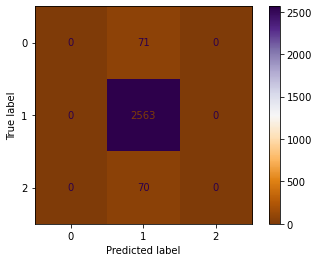

In [54]:
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='PuOr')